In [2]:
import simple_camera
import numpy as np
import pickle
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
%matplotlib inline


def read_obj(fpath):
    vertices = []
    faces = []
    vt = []
    colors = []
    for line in open(fpath):
        vals = line.rstrip('\r\n ').split(' ')
        if vals[0] == 'v':
            t = list(map(float, vals[1:4]))
            vertices.append(t)
            if len(vals[4:]) > 1:
                colors.append(list(map(float, vals[4:])))
            
        if vals[0] == 'vt':
            vt.append(list(map(float, vals[1:])))
            
        if vals[0] == 'f':
            f = []
            for p in vals[1:]:
                v = int(p.split('/')[0])
                f.append(v)
            faces.append(f)
    

    if len(colors) > 0:
        colors = np.array(colors).astype(np.float32)
    else:
        colors = None
        
    vertices = np.array(vertices)
    faces = np.array(faces)
    print(faces.shape)
    vt = np.array(vt)
    
    faces = faces - 1
    return vertices.astype(np.float32), faces.astype(np.int32)


def save_obj(fpath, vertices, faces):
    vertices = vertices.astype(np.float32)
    faces = faces.astype(np.int32)
    with open(fpath, 'w') as f:
        for v in vertices:
            v = list(map(str, v))
            f.write('v ' + ' '.join(v) + '\n')
        for triangle in faces:
            triangle = list(map(str, triangle+1))
            f.write('f ' + ' '.join(triangle) + '\n')


# with open('../../FLAME2019/generic_model.pkl', 'rb') as f:
#     dd = pickle.load(f, encoding="latin1")
# vertices = dd['v_template']
# faces = dd['f'].astype(np.int32)

vertices, faces = read_obj('generic_head.obj')

(9976, 3)


In [3]:


def get_zyx_rotation(angles):
    ''' get rotation matrix from three rotation angles(degree). right-handed.
    Args:
        angles: [3,]. x, y, z angles
        x: pitch. positive for looking down.
        y: yaw. positive for looking left.
        z: roll. positive for tilting head right.
    Returns:
        R: [3, 3]. rotation matrix.
    '''
    x, y, z = np.deg2rad(angles[0]), np.deg2rad(angles[1]), np.deg2rad(angles[2])
    # x
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(x), -np.sin(x)],
                   [0, np.sin(x), np.cos(x)]])
    # y
    Ry = np.array([[np.cos(y), 0, np.sin(y)],
                   [0, 1, 0],
                   [-np.sin(y), 0, np.cos(y)]])
    # z
    Rz = np.array([[np.cos(z), -np.sin(z), 0],
                   [np.sin(z), np.cos(z), 0],
                   [0, 0, 1]])

    R = Rz.dot(Ry.dot(Rx))
    return R.astype(np.float32)


def Rx(deg):
    x = np.deg2rad(deg)
    return np.array([[1, 0, 0],
                   [0, np.cos(x), -np.sin(x)],
                   [0, np.sin(x), np.cos(x)]])

def Ry(deg):
    y = np.deg2rad(deg)
    return np.array([[np.cos(y), 0, np.sin(y)],
                   [0, 1, 0],
                   [-np.sin(y), 0, np.cos(y)]])

def Rz(deg):
    z = np.deg2rad(deg)
    return np.array([[np.cos(z), -np.sin(z), 0],
                   [np.sin(z), np.cos(z), 0],
                   [0, 0, 1]])

def Pitch(deg):
    return Rx(deg)

def Yaw(deg):
    return Ry(deg)

def Roll(deg):
    return Rz(deg)


def render(vertices, faces=faces, size=512, bg_color=0, oversampling=2, smooth=True):
    height = width = size
    bg_img = np.zeros((height*oversampling, width*oversampling, 3), dtype=np.float32) + bg_color
    img = Image.fromarray(simple_camera.render_perspective_camera(vertices, faces,
                                                                  width=width*oversampling, 
                                                                  height=height*oversampling,
                                                                  scale=2.0, 
                                                                  light_positions = np.array([[   0,    0, -500]]),
                                                                  light_intensities = np.array([[1.5, 1.5, 1.5]]),
                                                                  bg_img=bg_img))
    if smooth:
        img = img.filter(ImageFilter.GaussianBlur(radius=1.5*size/512))
    return img.resize((width, height), Image.ANTIALIAS)


def save_figure(fname, **kwargs):
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(f'assets/{fname}',  bbox_inches = 'tight', pad_inches=0, **kwargs)

# Rotation Order matters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.


<Figure size 432x288 with 0 Axes>

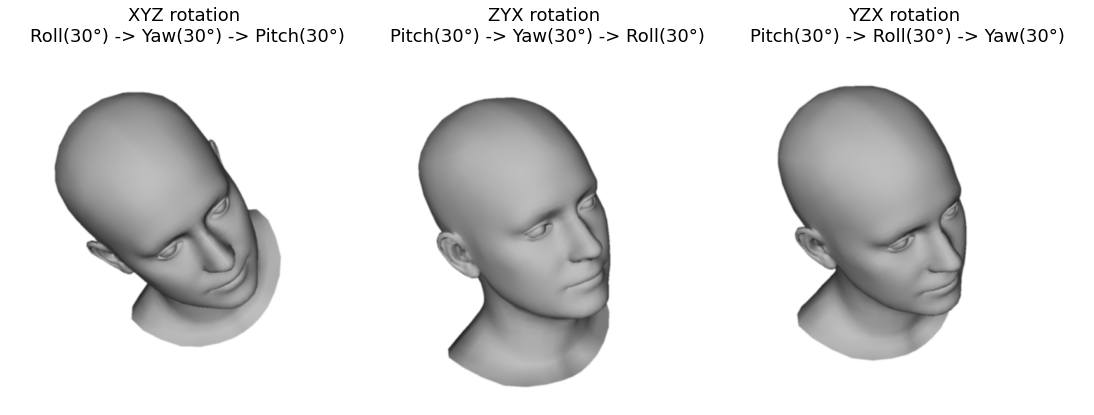

In [4]:
#X - pitch
#Y - yaw
#Z - roll

angle = 30
R1 = Rx(angle).dot(Ry(angle)).dot(Rz(angle))
R2 = Rz(angle).dot(Ry(angle)).dot(Rx(angle))
R3 = Ry(angle).dot(Rz(angle)).dot(Rx(angle))

all_rots = [(f'XYZ rotation \nRoll({angle}°) -> Yaw({angle}°) -> Pitch({angle}°)', R1), 
            (f'ZYX rotation \nPitch({angle}°) -> Yaw({angle}°) -> Roll({angle}°)', R2), 
            (f'YZX rotation \nPitch({angle}°) -> Roll({angle}°) -> Yaw({angle}°)', R3)]

plt.tight_layout()
_ = plt.figure(figsize=(15, 10))
plt.subplots_adjust(wspace=0, hspace=0)
for i, (order,R) in enumerate(all_rots):    
    plt.subplot(1,len(all_rots),i+1)
    img = render(R.dot(vertices.T).T, bg_color=1, size=512)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{order}', fontsize=18)

save_figure('rotation_orders.jpg', quality=80)

In [5]:
from moviepy.editor import *
from tqdm.notebook import tqdm
from PIL import ImageDraw, ImageFont

fnt = ImageFont.truetype('../../../fonts/helvetica/HelveticaRegular/HelveticaRegular.ttf', 14)

def animate_orders(rotations, max_angle, size=512):
    init_v = vertices.copy()
    frames = []
    text = ''
    for R in rotations:
        for angle in tqdm(range(0, max_angle+1)):
            v = R(angle).dot(init_v.T).T
            img = render(v, bg_color=1, size=size)
            draw = ImageDraw.Draw(img)
            cur_text = R.__name__[1:].upper() + f'({angle}°)'
            draw.text((10, 5), text + cur_text, font=fnt, fill=(0, 0, 0))
            frames.append(np.array(img))
        
        text = text + cur_text + ' => '
        init_v = v
    frames.extend([frames[-1]]*20)
    print(len(frames))
    clip = ImageSequenceClip(frames, fps=30)  
    return clip

In [ ]:
video1 = animate_orders([Rx,Ry,Rz], 30, size=256)
video2 = animate_orders([Rz,Ry,Rx], 30, size=256)
final_video = clips_array([[video1, video2]])
final_video.ipython_display(height=256)

# Gimbal lock example

<Figure size 432x288 with 0 Axes>

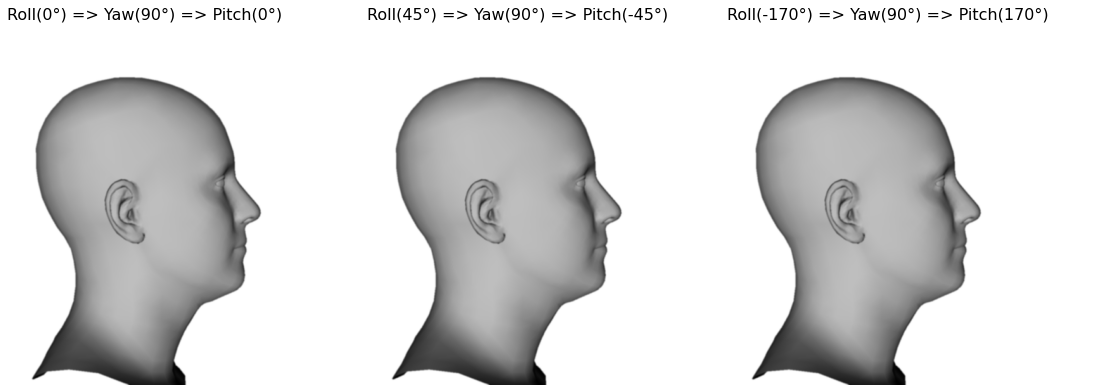

In [7]:
#X - pitch
#Y - yaw
#Z - roll


R1 = Pitch(0).dot(Yaw(90)).dot(Roll(-0))
R2 = Pitch(170).dot(Yaw(90)).dot(Roll(-170))
R3 = Pitch(-100).dot(Yaw(90)).dot(Roll(100))

all_rots = [(f'Roll(0°) => Yaw(90°) => Pitch(0°)', R1), 
            (f'Roll(45°) => Yaw(90°) => Pitch(-45°)', R2),
            (f'Roll(-170°) => Yaw(90°) => Pitch(170°)', R3)]

plt.tight_layout()
_ = plt.figure(figsize=(15, 10))
plt.subplots_adjust(wspace=0, hspace=0)
nb_rows = 1
for i, (order,R) in enumerate(all_rots):    
    plt.subplot(nb_rows, len(all_rots) // nb_rows, i+1)
    img = render(R.dot(vertices.T).T, bg_color=1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{order}', fontsize=16, loc='left')

save_figure('gimbal_lock.jpg', quality=80)

In [8]:
def animate_gimbal(middle_angle=90, size=512):
    init_v = vertices.copy()
    frames = []
    text = ''
    pitches = np.arange(0, 91)
    rolls = pitches
    fnt = ImageFont.truetype('../../../fonts/helvetica/HelveticaRegular/HelveticaRegular.ttf', 14)
    for pitch, roll in tqdm(zip(pitches, rolls)):
        R = Roll(roll).dot(Yaw(middle_angle)).dot(Pitch(pitch))
        v = R.dot(init_v.T).T
        img = render(v, bg_color=1, size=size)
        draw = ImageDraw.Draw(img)
        text = f'Pitch({pitch}°) => Yaw({middle_angle}°) => Roll({roll}°)'
        draw.text((10, 10), text, font=fnt, fill=(0, 0, 0))
        frames.append(np.array(img))
        
    clip = ImageSequenceClip(frames, fps=30)  
    return clip

In [ ]:
video1 = animate_gimbal(middle_angle=0, size=256)
video2 = animate_gimbal(middle_angle=80, size=256)
video3 = animate_gimbal(middle_angle=90, size=256)

final_video = clips_array([[video1, video2, video3]])
final_video.ipython_display(height=256)

In [205]:
final_video.write_gif('assets/gimbal_anim.gif')

t:   8%|▊         | 7/91 [00:00<00:01, 66.94it/s, now=None]

MoviePy - Building file assets/gimbal_anim.gif with imageio.


# Show Yaw, Pitch, Roll animations

In [74]:
def animate_angle(R, label, size=512):
    init_v = vertices.copy()
    frames = []
    text = ''
    angles = np.hstack([np.arange(-30, 0, 2)[::-1], 
                       np.arange(-29, 0, 2), 
                       np.arange(0, 31, 2), 
                       np.arange(0, 30, 2)[::-1]])
    fnt = ImageFont.truetype('../../../fonts/helvetica/HelveticaRegular/HelveticaRegular.ttf', 16)
    for angle in tqdm(angles):
        v = R(angle).dot(init_v.T).T
        img = render(v, bg_color=1, size=size)
        W,H = img.size
        draw = ImageDraw.Draw(img)
        text = f'{label}({angle}°)'
        w, h = draw.textsize(label)
        w += draw.textsize('(xxx)')[0]
        draw.text(((W-w)/2, 10), text, font=fnt, fill=(0, 0, 0))
        frames.append(np.array(img))
        
    clip = ImageSequenceClip(frames, fps=30)  
    return clip

In [ ]:
yaw_clip = animate_angle(Yaw, 'Yaw', size=256)
pitch_clip = animate_angle(Pitch, 'Pitch', size=256)
roll_clip = animate_angle(Roll, 'Roll', size=256)
final_video = clips_array([[yaw_clip, pitch_clip, roll_clip]])
final_video.ipython_display(height=256)

In [76]:
final_video.write_gif('assets/ypr_anim.gif')

t:  11%|█▏        | 7/62 [00:00<00:00, 68.34it/s, now=None]

MoviePy - Building file assets/ypr_anim.gif with imageio.
